# GRU 모델, 승률 예측

In [59]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from tensorflow.keras.models import save_model, load_model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import ADASYN, SMOTE
import tensorflowjs as tfjs
import matplotlib.pyplot as plt

In [61]:
# txt 파일 읽기

max_len = 0
data_path = '../GameData'
add_path = '_0516.txt'
with open(f'{data_path}/input{add_path}', 'r') as file:
    for line in file:
        row = line.strip().split(',')
        row_len = len(row)
        if row_len > max_len:
            max_len = row_len

print(f"가장 긴 행의 길이: {max_len}")

raw_input_data = pd.read_table(f'{data_path}/input{add_path}', delimiter=',', header=None, names=range(max_len))
output_data = pd.read_table(f'{data_path}/output{add_path}', delimiter=',', header=None)

print(output_data[0].value_counts())


가장 긴 행의 길이: 4092
0
0    2448
1    1037
2     221
Name: count, dtype: int64


In [62]:
# 데이터에서 나타나지 않는 값을 패딩 값으로 설정
input_data = raw_input_data.fillna(0)

# 데이터 정규화
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

print(input_data.shape)
print(output_data.shape)

(3706, 4092)
(3706, 1)


In [45]:
# 시퀀스 길이로 나누기
n_games = output_data.shape[0]         # 게임 수
n_features = 16*4+2      # 단위 시간 1회마다 주어지는 input의 개수
n_sequences = max_len // n_features    # 단위 시간의 횟수

print(max_len, n_games, n_sequences, n_features)

# Numpy 배열의 reshape 메서드 사용
X = input_data.reshape(n_games, n_sequences, n_features)
y = output_data.values

# 데이터의 크기 출력
print(X.shape)
print(y.shape)

4092 3706 62 66
(3706, 62, 66)
(3706, 1)


In [63]:
# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# GridSearchCV를 위한 GRU 모델 구성. 은닉층 다양화
def create_model():
    model = Sequential()
#     model.add(Masking(mask_value=padding_value, input_shape=(None, n_features)))
    model.add(GRU(128, return_sequences=True, input_shape=(None, n_features)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(128))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[f1])
    return model
    
def f1(train_y, test_y):
    """
    F1 score 계산을 위한 함수
    """
    true_positives = K.sum(K.round(K.clip(train_y * test_y, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(test_y, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(train_y, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

# KerasClassifier 객체 생성
model = KerasClassifier(model=create_model, verbose=2)

# 하이퍼파라미터 그리드 설정

param_grid = {
    'batch_size': [16, 32],
    'epochs': [20, 50, 100],
}


# GridSearchCV 수행
grid = GridSearchCV(estimator=model, param_grid=param_grid, return_train_score=True, error_score='raise')
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

# 결과 출력
print("최적의 결과: %f (받은 파라미터: %s)" % (grid_result.best_score_, grid_result.best_params_))

# 모델 객체 할당 여부 확인
if grid_result.best_estimator_.model is None:
    model = grid_result.best_estimator_.build_fn()
else:
    model = grid_result.best_estimator_.model()


Epoch 1/20
149/149 - 9s - loss: 0.5648 - f1: 0.5469 - val_loss: 0.4905 - val_f1: 0.4720 - 9s/epoch - 60ms/step
Epoch 2/20
149/149 - 1s - loss: 0.2447 - f1: 0.5295 - val_loss: 0.4322 - val_f1: 0.5249 - 1s/epoch - 9ms/step
Epoch 3/20
149/149 - 1s - loss: 0.2298 - f1: 0.5268 - val_loss: 0.4487 - val_f1: 0.5120 - 1s/epoch - 9ms/step
Epoch 4/20
149/149 - 1s - loss: 0.2024 - f1: 0.5398 - val_loss: 0.3393 - val_f1: 0.5255 - 1s/epoch - 8ms/step
Epoch 5/20
149/149 - 1s - loss: 0.1863 - f1: 0.5318 - val_loss: 0.2216 - val_f1: 0.5354 - 1s/epoch - 9ms/step
Epoch 6/20
149/149 - 1s - loss: 0.1614 - f1: 0.5239 - val_loss: 0.1488 - val_f1: 0.5469 - 1s/epoch - 9ms/step
Epoch 7/20
149/149 - 1s - loss: 0.1544 - f1: 0.5342 - val_loss: 0.2721 - val_f1: 0.5335 - 1s/epoch - 8ms/step
Epoch 8/20
149/149 - 1s - loss: 0.1458 - f1: 0.5207 - val_loss: 0.1203 - val_f1: 0.5100 - 1s/epoch - 9ms/step
Epoch 9/20
149/149 - 1s - loss: 0.1367 - f1: 0.5243 - val_loss: 0.1696 - val_f1: 0.5284 - 1s/epoch - 8ms/step
Epoch 10/

In [53]:
# best model 저장
save_model(model, f'./best_model/0518/{grid_result.best_score_}_GRU_epoch_100_batch_16.h5')
# save_model(model, '/home/j-k8e202/test_kyj/%f_LSTM_model.h5' % (grid_result.best_score_))


In [4]:
# 게임 중간까지의 데이터를 줄 때, 승률 예측이 잘 되나?
# 예측할 게임 중간 데이터
mid_game_data = X_test[:100, :30, :]  # 임의의 데이터 예시


for i in range(1, 123):
    mid_game_data = X_test[:1, :i, :]  # 임의의 데이터 예시
    prediction = model.predict(mid_game_data)
    
    print(prediction)


NameError: name 'X_test' is not defined

In [3]:
print("최적의 결과: %f (받은 파라미터: %s)" % (grid_result.best_score_, grid_result.best_params_))

best_model = grid_result.best_estimator_.model

SyntaxError: positional argument follows keyword argument (2587559057.py, line 5)

In [54]:
# 저장된 모델 불러오기
loaded_model = load_model('./best_model/0518/0.9811027300487671_GRU_epoch_100_batch_16.h5.h5')

# loaded_model = model
# 모델 구조 및 파라미터 확인
print(loaded_model.summary())

# 해당 데이터의 confution matrix
df = pd.read_table('./GameData/input_0517_2.txt', delimiter=',', header=None, names=range(max_len))
rdf = pd.read_table('./GameData/output_0517_2.txt', delimiter=',', header=None)

# 데이터 정규화
df = df.fillna(0)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

games = rdf.shape[0]
featurse_dim = 66 # 현재는 8개의 캐릭터, 2개의 팀, [x, y 좌표, 체력] 총 48개의피쳐로 테스트 중. 나중에 수정 가능(16*3)
# 수정 : [x, y좌표, 체력, 교전여부] -> 4*16 = 64, 각 팀별 스코어 2  -> 66
timesteps = max_len // featurse_dim
featurse = df.reshape(games, timesteps, featurse_dim)
labels = rdf.values 

pred_y = loaded_model.predict(featurse)

pred = []
tmp = 0
for i in pred_y :
    if i[0] > i[1] and i[0] > i[2] :
        tmp = 0
    elif i[1] > i[0] and i[1] > i[2] :
        tmp = 1
    elif i[2] > i[0] and i[2] > i[1] :
        tmp = 2
    pred.append([tmp])
    
print(classification_report(labels, pred))

Model: "sequential_374"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_434 (GRU)               (None, None, 128)         75264     
                                                                 
 dropout_486 (Dropout)       (None, None, 128)         0         
                                                                 
 batch_normalization_122 (Ba  (None, None, 128)        512       
 tchNormalization)                                               
                                                                 
 gru_435 (GRU)               (None, 128)               99072     
                                                                 
 dropout_487 (Dropout)       (None, 128)               0         
                                                                 
 batch_normalization_123 (Ba  (None, 128)              512       
 tchNormalization)                                  

In [56]:
# 저장된 모델 불러오기
# loaded_model = load_model('./best_model/0509/0.8751623672576455_GRU_hidden_1_nUnit_256_dropoutRate_0.5_epoch_80_batch_.h5')

# 현재 학습한 모델을 바로 사용
loaded_model = model

# 모델 구조 및 파라미터 확인
print(loaded_model.summary())

df = pd.read_table('./GameData/input_0517_only.txt', delimiter=',', header=None, names=range(max_len))
rdf = pd.read_table('./GameData/output_0517_only.txt', delimiter=',', header=None)

# 데이터 정규화
df = df.fillna(0)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

games = rdf.shape[0]
features_dim = 66 # [x, y좌표, 체력, 교전여부] -> 4*16 = 64, 각 팀별 스코어 2  -> 66
timesteps = max_len // features_dim 

features = df.reshape(games, timesteps, features_dim)
labels = rdf.values 
pred_y = loaded_model.predict(features)

pred = []
tmp = 0
for i in pred_y :
    if i[0] > i[1] and i[0] > i[2] :
        tmp = 0
    elif i[1] > i[0] and i[1] > i[2] :
        tmp = 1
    elif i[2] > i[0] and i[2] > i[1] :
        tmp = 2
    pred.append([tmp])
    
print(classification_report(labels, pred))

Model: "sequential_374"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_434 (GRU)               (None, None, 128)         75264     
                                                                 
 dropout_486 (Dropout)       (None, None, 128)         0         
                                                                 
 batch_normalization_122 (Ba  (None, None, 128)        512       
 tchNormalization)                                               
                                                                 
 gru_435 (GRU)               (None, 128)               99072     
                                                                 
 dropout_487 (Dropout)       (None, 128)               0         
                                                                 
 batch_normalization_123 (Ba  (None, 128)              512       
 tchNormalization)                                  

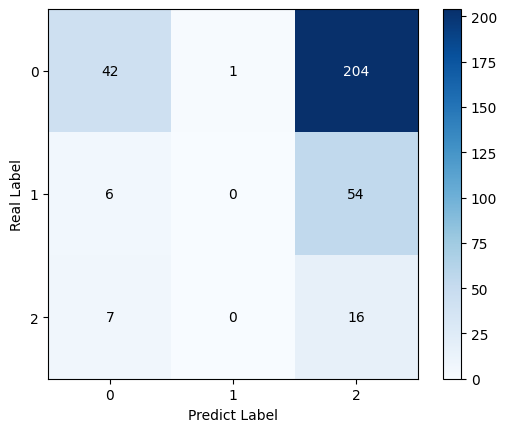

0.17575757575757575


In [57]:
# 삼항 혼동 행렬 계산
cm = confusion_matrix(labels, pred)

# 혼동 행렬 그리기
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, [0, 1, 2])
plt.yticks(tick_marks, [0, 1, 2])

# 혼동 행렬의 값 표시
thresh = cm.max() / 2.
for i in range(3):
    for j in range(3):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predict Label')
plt.ylabel('Real Label')
plt.savefig('0517_5_oversampling_LSTM_model_.png')
plt.show()

print(accuracy_score(labels, pred))